In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr

In [2]:
# Load data
protein = pd.read_csv('../../db_tables/protein.tsv', sep= '\t')
disorder_region = pd.read_csv('../../db_tables/disorder_region.tsv', sep= '\t')
mutation = pd.read_csv('../../db_tables/mutation_new.tsv.gz', compression= 'gzip', sep='\t')
mutation_has_disorder_region = pd.read_csv('../../db_tables/mutation_has_disorder_region.tsv', sep='\t')

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Drop "_HUMAN" in protein name
protein.uniprot_name = protein.uniprot_name.apply(lambda x: x.split("_")[0])
# df with proteins name
protein_id = protein[['id_protein', 'uniprot_name', 'length']]

## How many disordered proteins in DisPhaseDB?

In [4]:
disorder_region.id_protein.nunique()

3426

In [5]:
# proportion of disordered proteins in DisPhase
dis_prop = round(disorder_region.id_protein.nunique() / protein.id_protein.nunique(), 2)
dis_prop

0.6

### Disorder content from MobiDB

In [6]:
# Disorder content from MobiDB
protein.disorder_content.notna().sum() # ok

3426

In [7]:
# Dataframe with protein disorder content info
protein_disorder = protein[protein.disorder_content.notnull()][['id_protein', 'uniprot_acc', 'uniprot_name', 'length', 'disorder_content']]
protein_disorder

,id_protein,uniprot_acc,uniprot_name,length,disorder_content
0,1,P35637,FUS,526,0.797
1,2,Q06787,FMR1,632,0.340
2,3,Q92804,RBP56,592,0.828
3,4,Q13148,TADBP,414,0.184
4,5,Q01844,EWS,656,0.649
...,...,...,...,...,...
5732,5733,Q9Y6I9,TX264,313,0.319
5734,5735,Q9Y6M4,KC1G3,447,0.213
5736,5737,Q9Y6R4,M3K4,1608,0.175
5737,5738,Q9Y6S9,RPKL1,549,0.157


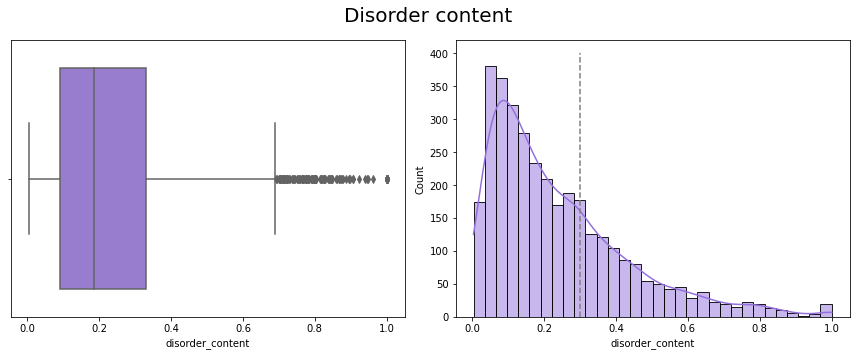

In [50]:
plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x= 'disorder_content', data= protein, color= 'mediumpurple')

plt.subplot(1,2,2)
sns.histplot(x= 'disorder_content', data= protein, kde= True, color= 'mediumpurple')
plt.vlines(0.3, 0, 400, colors= 'gray', linestyles= 'dashed')
plt.suptitle("Disorder content", size= 20)
plt.tight_layout()
plt.savefig('dis_content_distrib.png', dpi= 300)
plt.show()

### How many at different disorder content

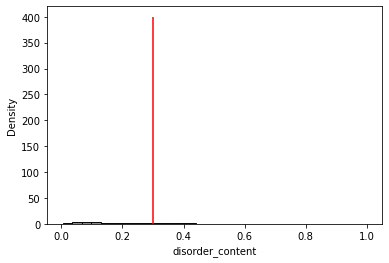

In [43]:
sns.histplot(x= 'disorder_content', data= protein, stat= 'density')
plt.vlines(0.3, 0, 400, colors= 'red')

In [28]:
# How many >= 30 %
protein[protein.disorder_content >= .2].shape[0] / protein.shape[0]

0.2795680195087964

## How many mutations in disordered proteins?

### First: check overlap between IDRs

In [111]:
disorder_region_pr = disorder_region.copy()
disorder_region_pr.columns = disorder_region_pr.columns.str.capitalize()

In [112]:
disorder_region_pr.columns

Index(['Start', 'End', 'Id_idr', 'Length', 'Id_protein'], dtype='object')

In [113]:
disorder_region_pr.rename(columns= {'Id_protein': 'Chromosome'}, inplace= True)

In [114]:
disorder_region_pr

,Start,End,Id_idr,Length,Chromosome
0,1,286,7538,286,1
1,375,424,7539,50,1
2,444,526,7540,83,1
3,325,349,7467,25,2
4,443,632,7468,190,2
...,...,...,...,...,...
8672,1244,1274,1198,31,5737
8673,1,136,1194,136,5737
8674,330,349,3394,20,5738
8675,260,325,3393,66,5738


In [115]:
# As pyranges object
disorder_region_pr = pr.PyRanges(disorder_region_pr)

In [116]:
# count overlaps
overlap = disorder_region_pr.count_overlaps(disorder_region_pr, overlap_col = 'overlap_count')

In [117]:
# to dataframe
overlap_df = overlap.as_df()

In [118]:
overlap_df

,Start,End,Id_idr,Length,Chromosome,overlap_count
0,1,286,7538,286,1,1
1,375,424,7539,50,1,1
2,444,526,7540,83,1,1
3,325,349,7467,25,2,1
4,443,632,7468,190,2,1
...,...,...,...,...,...,...
8672,1244,1274,1198,31,5737,1
8673,1,136,1194,136,5737,1
8674,330,349,3394,20,5738,1
8675,260,325,3393,66,5738,1


In [119]:
overlap_df.overlap_count.describe()

count    8677.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: overlap_count, dtype: float64

In [120]:
overlap_df[overlap_df.overlap_count > 1]

,Start,End,Id_idr,Length,Chromosome,overlap_count


con esto me aseguro de que no hay overlap entre las regiones IDR

In [131]:
del(disorder_region_pr, overlap, overlap_df)

---

In [121]:
# sum up the disorder regions length for each protein
# length_idr = disorder_region.groupby('id_protein').length.sum().to_frame('length_idr').reset_index()
# length_idr

## Analysis of mutations in disordered regions

In [15]:
# Add id_protein, protein name and protein length
mutation_has_disorder_region = mutation_has_disorder_region.merge(disorder_region[['id_protein', 'id_idr']]).merge(protein_id).rename(columns= {'length': 'length_protein'})
mutation_has_disorder_region

,id_mutation,id_idr,id_protein,uniprot_name,length_protein
0,35995,7538,1,FUS,526
1,35996,7538,1,FUS,526
2,35997,7538,1,FUS,526
3,35999,7538,1,FUS,526
4,36005,7538,1,FUS,526
...,...,...,...,...,...
256126,738036,3394,5738,RPKL1,549
256127,738048,3394,5738,RPKL1,549
256128,738063,3394,5738,RPKL1,549
256129,551013,3305,5739,RN215,377


In [124]:
# Add length_idr
#mutation_has_disorder_region = mutation_has_disorder_region.merge(length_idr)

In [125]:
# No. of mutations by disordered region
aux = mutation_has_disorder_region.groupby(['uniprot_name', 'id_idr'])[['length_protein']].size().sort_values(ascending= False).to_frame().reset_index().rename(columns= {0: 'no_mutations'})
aux.sort_values('uniprot_name')

,uniprot_name,id_idr,no_mutations
5580,1433E,1,12
4861,2A5A,2,15
2302,2A5B,3,30
7325,2A5B,4,7
1063,2A5D,5,55
...,...,...,...
192,ZYX,5760,138
5581,ZZZ3,5764,12
2001,ZZZ3,5762,34
2142,ZZZ3,5763,32


In [126]:
mutation_has_disorder_region[['uniprot_name', 'length_protein']].drop_duplicates()

,uniprot_name,length_protein
0,FUS,526
254,FMR1,632
385,RBP56,592
399,TADBP,414
428,EWS,656
...,...,...
255894,TX264,313
255925,KC1G3,447
255962,M3K4,1608
256094,RPKL1,549


In [127]:
# drop duplicates on mutations and add each IDR with its number of mutations
mutations_by_idr = mutation_has_disorder_region[['uniprot_name', 'length_protein']].drop_duplicates().merge(aux)
mutations_by_idr

,uniprot_name,length_protein,id_idr,no_mutations
0,FUS,526,7538,144
1,FUS,526,7540,81
2,FUS,526,7539,29
3,FMR1,632,7468,115
4,FMR1,632,7467,16
...,...,...,...,...
8092,M3K4,1608,1196,19
8093,M3K4,1608,1198,16
8094,RPKL1,549,3393,23
8095,RPKL1,549,3394,12


In [128]:
# Add idr length
mutations_by_idr = mutations_by_idr.merge(disorder_region[['id_idr', 'length']]).rename(columns= {'length': 'length_idr'})

In [129]:
mutations_by_idr['rate_by_idr'] = mutations_by_idr.no_mutations / mutations_by_idr.length_idr

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


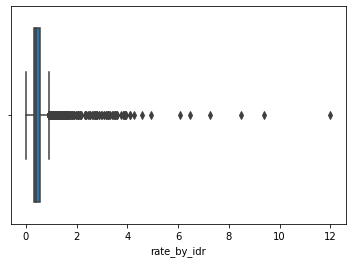

In [130]:
sns.boxplot('rate_by_idr', data= mutations_by_idr)
plt.show()

### Consider only mutated aa instead of no. of mutations

In [135]:
# Traer la posicion de los aa mutados
dis_mutations_aa = mutation[['id_mutation', 'start_aa']][mutation[['id_mutation', 'start_aa']].id_mutation.isin(mutation_has_disorder_region.id_mutation)]
dis_mutations_aa

,id_mutation,start_aa
113,114,62
114,115,20
121,122,1126
136,137,22
150,151,89
...,...,...
1647021,1647022,28
1647022,1647023,8
1647024,1647025,17
1647026,1647027,13


In [136]:
dis_mutations_aa.duplicated().any()

False

In [137]:
# merge position of the mutated aa
dis_mutations = mutation_has_disorder_region.merge(dis_mutations_aa, how='left')
dis_mutations

,id_mutation,id_idr,id_protein,uniprot_name,length_protein,start_aa
0,35995,7538,1,FUS,526,49
1,35996,7538,1,FUS,526,51
2,35997,7538,1,FUS,526,97
3,35999,7538,1,FUS,526,64
4,36005,7538,1,FUS,526,66
...,...,...,...,...,...,...
256126,738036,3394,5738,RPKL1,549,340
256127,738048,3394,5738,RPKL1,549,337
256128,738063,3394,5738,RPKL1,549,343
256129,551013,3305,5739,RN215,377,17


In [138]:
# Considerar una mutacion por residuo IDR. Ya no importa el id_mutation
dis_mutations.drop_duplicates(['id_protein', 'start_aa'], inplace= True)
dis_mutations

,id_mutation,id_idr,id_protein,uniprot_name,length_protein,start_aa
0,35995,7538,1,FUS,526,49
1,35996,7538,1,FUS,526,51
2,35997,7538,1,FUS,526,97
3,35999,7538,1,FUS,526,64
4,36005,7538,1,FUS,526,66
...,...,...,...,...,...,...
256124,738014,3394,5738,RPKL1,549,335
256125,738033,3394,5738,RPKL1,549,333
256126,738036,3394,5738,RPKL1,549,340
256127,738048,3394,5738,RPKL1,549,337


# quede aqui

In [39]:
mutation_has_disorder_region.groupby('uniprot_name').size().sort_values(ascending= False).to_frame().reset_index().rename(columns= {0: 'no_mutations'})

,uniprot_name,no_mutations
0,APC,4911
1,FILA,3740
2,KMT2D,3133
3,PCLO,1919
4,BRCA1,1397
...,...,...
3229,SEPT7,1
3230,DIM1,1
3231,SRY,1
3232,ELYS,1


In [77]:
disorder_mutations = mutation_has_disorder_region.groupby('uniprot_name').size().sort_values(ascending= False).to_frame().reset_index().rename(columns= {0: 'no_mutations'})

In [85]:
disorder_mutations = disorder_mutations.merge(protein[['uniprot_name', 'length']])

In [107]:
disorder_mutations

,uniprot_name,no_mutations,length,rate
0,APC,4911,2843,1.727401
1,FILA,3740,4061,0.920955
2,KMT2D,3133,5537,0.565830
3,PCLO,1919,5142,0.373201
4,BRCA1,1397,1863,0.749866
...,...,...,...,...
3229,SEPT7,1,437,0.002288
3230,DIM1,1,313,0.003195
3231,SRY,1,204,0.004902
3232,ELYS,1,2266,0.000441


In [87]:
disorder_mutations['rate'] = disorder_mutations.no_mutations / disorder_mutations.length

In [91]:
disorder_mutations

,uniprot_name,no_mutations,length,rate
0,APC,4911,2843,1.727401
1,FILA,3740,4061,0.920955
2,KMT2D,3133,5537,0.565830
3,PCLO,1919,5142,0.373201
4,BRCA1,1397,1863,0.749866
...,...,...,...,...
3229,SEPT7,1,437,0.002288
3230,DIM1,1,313,0.003195
3231,SRY,1,204,0.004902
3232,ELYS,1,2266,0.000441


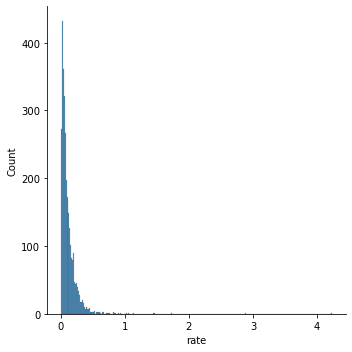

In [90]:
sns.displot(x= 'rate', data= disorder_mutations)

## agregar: enrichment IDRs con respecto a no-IDR